# Preliminaries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import math
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# Cleaning the data

In [52]:
# Read the CSV files
df1 = pd.read_csv('game_info.csv')
df2 = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
df3 = pd.read_csv('games.csv')

# Standardizing the column names
df2.columns = df2.columns.str.lower()
df1.columns = df1.columns.str.lower()

# Drop rows where 'genres' is missing
df1 = df1.dropna(subset=['genres'])

# Standardize values with the same meaning
df2['genre']= df2['genre'].replace('Role-Playing', 'RPG')
df2['genre']= df2['genre'].replace('Platform', 'Platformer')

# This will only keep rows where the 'name' is found in both dataframes
merged_df = pd.merge(df2, df1, on='name', how='left', suffixes=('_df2', '_df1'))

# Update 'genre' column with 'genres' value if 'genres' is not empty
merged_df['genre'] = merged_df.apply(lambda row: row['genres'] if pd.notna(row['genres']) else row['genre'], axis=1)

columns_to_drop=['platform', 'critic_score',
       'critic_count', 'user_score', 'user_count', 'developer', 'rating_df2',
       'id', 'slug', 'metacritic', 'released', 'tba', 'updated', 'website',
       'rating_df1', 'rating_top', 'playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'platforms', 'developers', 'publishers', 'esrb_rating',
       'added_status_yet', 'added_status_owned', 'added_status_beaten',
       'added_status_toplay', 'added_status_dropped', 'added_status_playing', 'genres']
# Drop the redundant columns
genre_and_sales_df = merged_df.drop(columns=columns_to_drop)
genre_and_sales_df

,name,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,Wii Sports,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53
1,Super Mario Bros.,1985.0,Action||Adventure||Platformer,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,1996.0,RPG,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...
16718,Samurai Warriors: Sanada Maru,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01
16719,LMA Manager 2007,2006.0,Strategy||Sports,Codemasters,0.00,0.01,0.00,0.00,0.01
16720,Haitaka no Psychedelica,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01
16721,Spirits & Spells,2003.0,Platformer,Wanadoo,0.01,0.00,0.00,0.00,0.01


Currently games which were released on multiple platforms have a separate row for each platform. We will aggregate the sales on all platforms together under each game.

In [53]:
aggregation_dict = {
    'name': 'first',
    'year_of_release': 'first',
    'publisher': 'first',
    'genre': 'first',
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum',
    'global_sales': 'sum'
}
merged_sales = genre_and_sales_df.groupby('name', as_index=False).agg(aggregation_dict)

Now we will separate all of the genre values in the genre column.

In [55]:
# Get unique genre names
genre_series = merged_sales['genre'].str.split('\|\|', expand=True).stack()
unique_genres = genre_series.unique()

Create a new dataframe with only relevant info and plot the total number of global sales by genre.

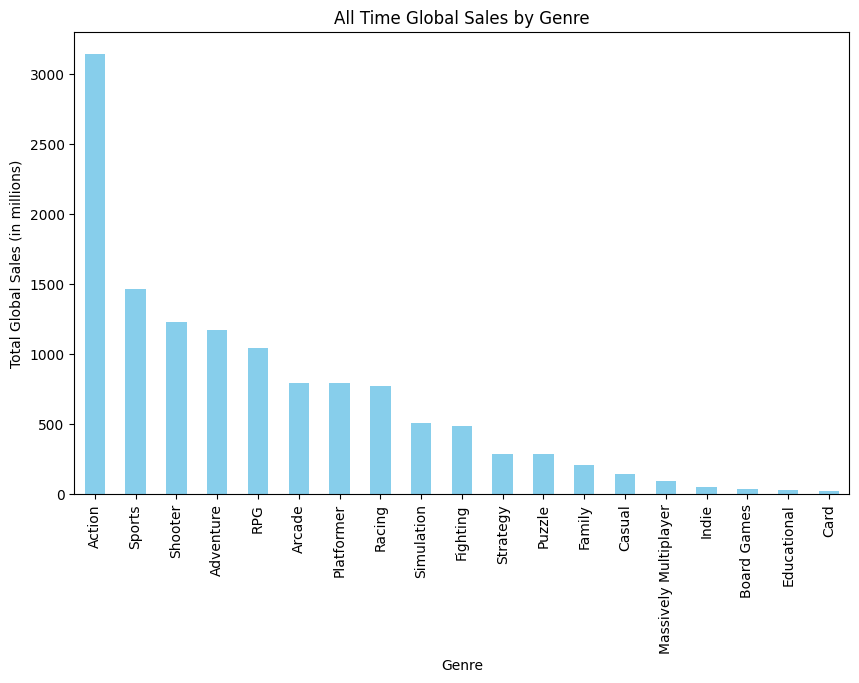

In [56]:
# Create a new DataFrame with name, release year, genre and sales 
genres_df = pd.DataFrame({
    'name': merged_sales['name'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'year_of_release': merged_sales['year_of_release'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'publisher': merged_sales['publisher'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'genre': genre_series.values,
    'na_sales': merged_sales['na_sales'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'eu_sales': merged_sales['eu_sales'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'jp_sales': merged_sales['jp_sales'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'other_sales': merged_sales['other_sales'].iloc[genre_series.index.get_level_values(0)].tolist(),
    'global_sales': merged_sales['global_sales'].iloc[genre_series.index.get_level_values(0)].tolist()
})

# Remove 'Misc', because it is ambiguous and doesn't contribute anything meaningful to the analysis
genres_df = genres_df[genres_df['genre'] != 'Misc']

# Group by 'genre' and sum the global sales
total_sales_by_genre = genres_df.groupby('genre')['global_sales'].sum().sort_values(ascending=False)

# Plot bar chart
total_sales_by_genre.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('All Time Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Global Sales (in millions)')
plt.show()

We can see that action games have by far the highest sales. It is followed by sports, shooter, adventure and RPG. (Note that since games can have more than one genre, these columns do not add up to the total number of global sales.) To get further insight we need to also find the relative frequencies of genres. 

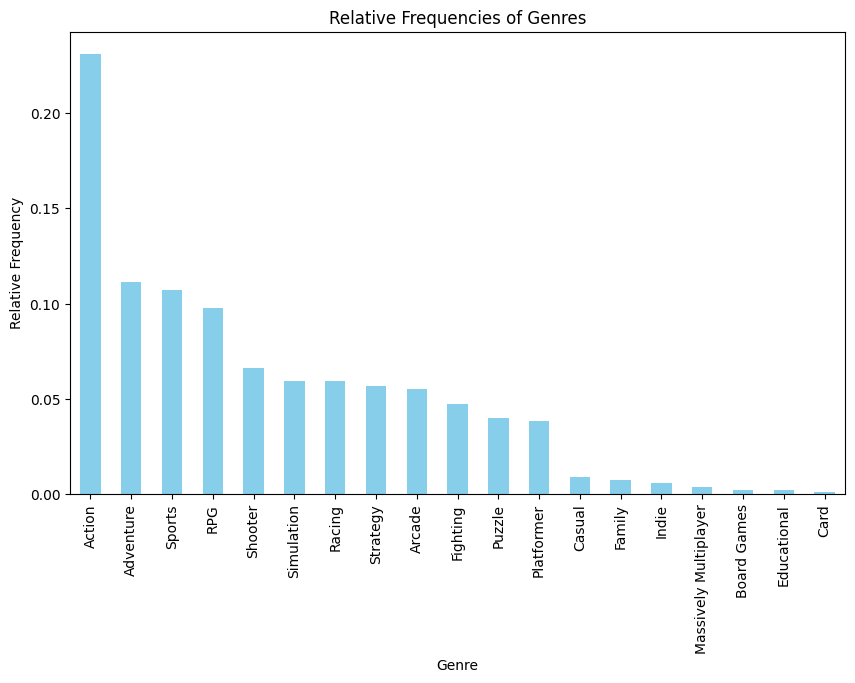

In [34]:
# Count the occurrences of each genre
genre_counts = genres_df['genre'].value_counts()
# Calculate relative frequencies (proportions)
relative_frequencies = (genre_counts / len(genres_df)).sort_values(ascending=False)

# Plot bar chart with relative frequencies
relative_frequencies.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Relative Frequencies of Genres')
plt.xlabel('Genre')
plt.ylabel('Relative Frequency')
plt.show()

We can see that 20% of the games in the dataset are listed under the action category and the top 5 games with highest sales also have the highest relative frequencies. This means that the high sales numbers could simply be because these types of games make up a significant percentage of the market, not because they are inherently more likely to have higher sales. <br>
To get more insight, we need to also look at the average sales. 

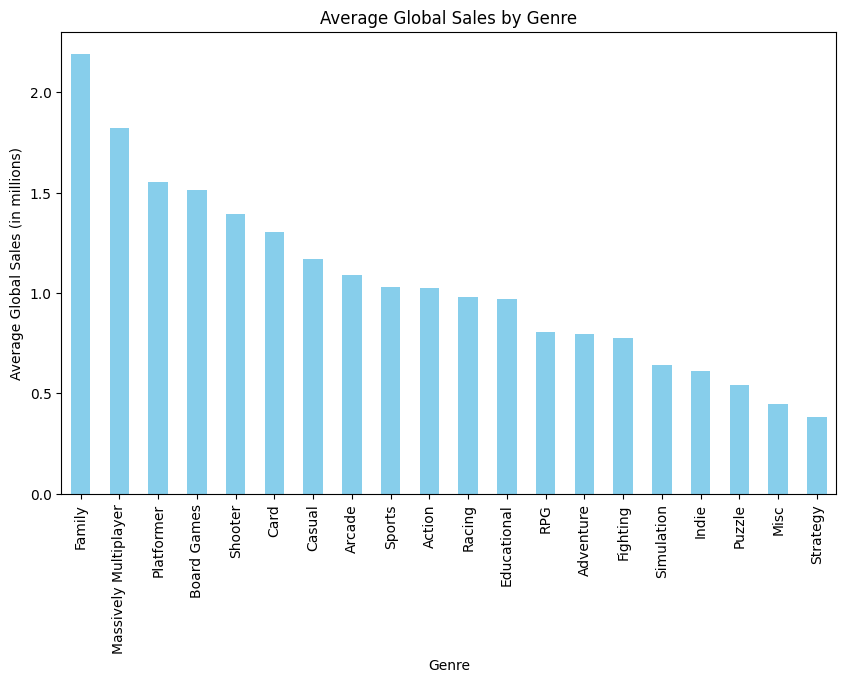

In [29]:
# Group by 'genre' and calculate the average global sales
average_sales_by_genre = genres_df.groupby('genre')['global_sales'].mean().sort_values(ascending=False)

# Plot bar chart with average global sales
average_sales_by_genre.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Average Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Global Sales (in millions)')
plt.show()

As we can see, four genres fell out of the TOP5. The only genre to retain its spot was the shooter genre. <br>
Family, massively multiplayer (MMO), platformer and board games seem to have the highest average sales. 

The averages could be skewed due to low sample sizes and significant ouliers, so we can also find the median global sales. 

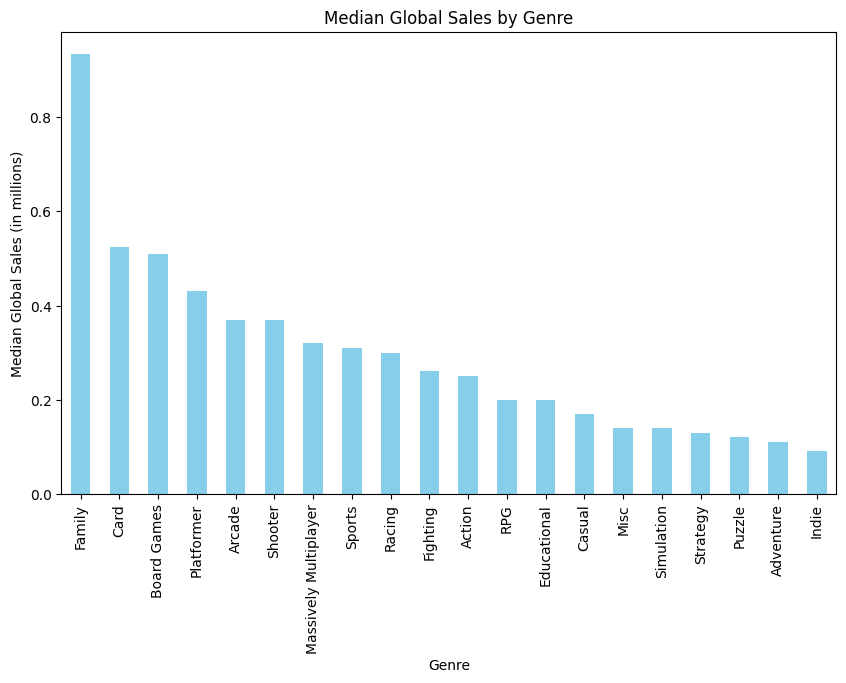

In [35]:
# Group by 'genre' and calculate the average global sales
average_sales_by_genre = genres_df.groupby('genre')['global_sales'].median().sort_values(ascending=False)

# Plot bar chart with average global sales
average_sales_by_genre.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Median Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Median Global Sales (in millions)')
plt.show()

We can see that family games also have the highest median sales. Board games and platformers remained in the TOP5. Shooter games 
were pushed out by a very small margin. 

What we can take away from this is that family games on average have the highest sales. They also have a low relative frequency, which could indicate an untapped market. Platformers and board games indicate a similar trend. <br> 
The most consistenly high ranking in all metrics is the shooter genre. Shooters have high average sales despite the high amount of competition due to the high relative frequency. 

The following is plots for average and total sales in all regions by genre over time. 

In [42]:
def plot_mean_by_genre_per_year(column):
    # Group by 'genre' and 'year_of_release' and calculate the average global sales
    average_sales_by_genre_year = genres_df.groupby(['genre', 'year_of_release'])[column].mean().reset_index()

    # Get unique genres for subplot creation
    unique_genres = genres_df['genre'].unique()

    # Calculate the number of rows and columns needed for the grid
    num_plots = len(unique_genres)
    num_cols = 3  # Set the number of columns per row
    num_rows = math.ceil(num_plots / num_cols)

    # Create subplots for each genre in a grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 3 * num_rows))

    # Iterate through genres and plot average global sales for each year using scatter plot
    for i, genre in enumerate(unique_genres):
        genre_data = average_sales_by_genre_year[average_sales_by_genre_year['genre'] == genre]
        ax = axes[i // num_cols, i % num_cols]  # Calculate the current subplot position
        ax.scatter(genre_data['year_of_release'], genre_data[column], color='skyblue')
        ax.set_title(f'{genre}')
        ax.set_xlabel('Year')
        ax.set_ylabel(f'Average {column} (in millions)')
        ax.set_xlim(1980, 2020)
        ax.set_ylim(0, 16)

    # Remove any empty subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

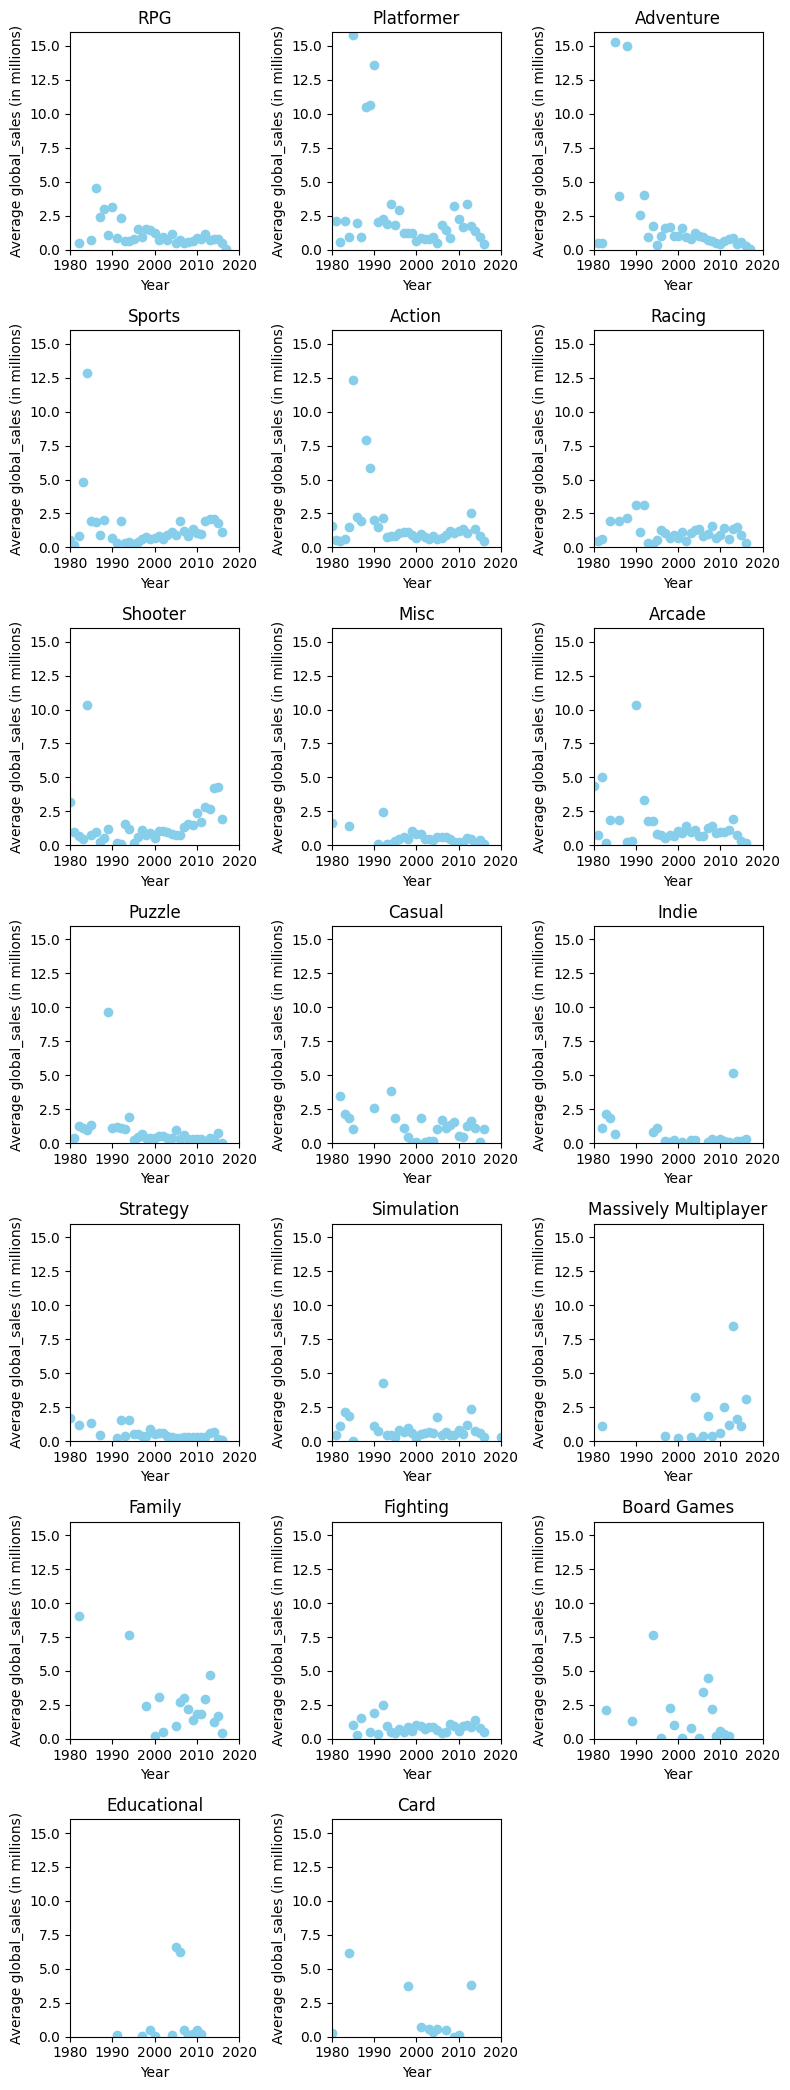

In [43]:
plot_mean_by_genre_per_year('global_sales')

In [44]:
def plot_total_by_genre_per_year(column):
    # Group by 'genre' and 'year_of_release' and calculate the average global sales
    total_sales_by_genre_year = genres_df.groupby(['genre', 'year_of_release'])[column].sum().reset_index()

    # Get unique genres for subplot creation
    unique_genres = genres_df['genre'].unique()

    # Calculate the number of rows and columns needed for the grid
    num_plots = len(unique_genres)
    num_cols = 3  # Set the number of columns per row
    num_rows = math.ceil(num_plots / num_cols)

    # Create subplots for each genre in a grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 3 * num_rows))

    # Iterate through genres and plot average global sales for each year using scatter plot
    for i, genre in enumerate(unique_genres):
        genre_data = total_sales_by_genre_year[total_sales_by_genre_year['genre'] == genre]
        ax = axes[i // num_cols, i % num_cols]  # Calculate the current subplot position
        ax.scatter(genre_data['year_of_release'], genre_data[column], color='skyblue')
        ax.set_title(f'{genre}')
        ax.set_xlabel('Year')
        ax.set_ylabel(f'Total {column} (in millions)')
        ax.set_xlim(1980, 2020)
        ax.set_ylim(0, 300)

    # Remove any empty subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

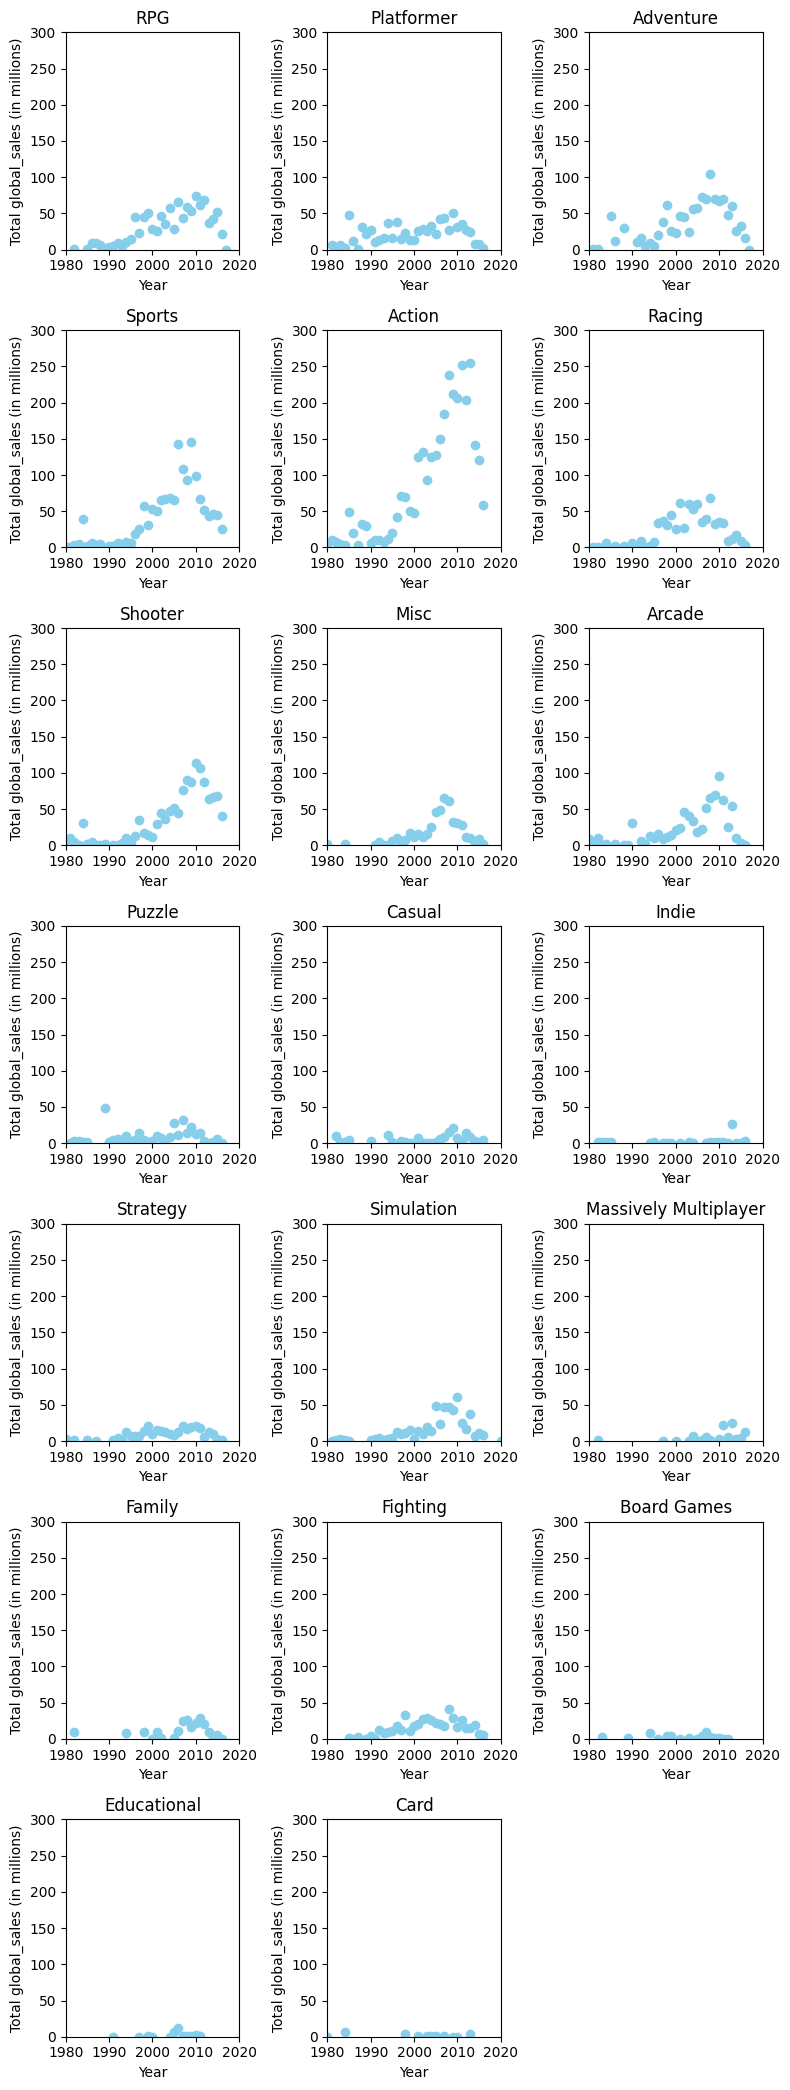

In [45]:
plot_total_by_genre_per_year('global_sales')

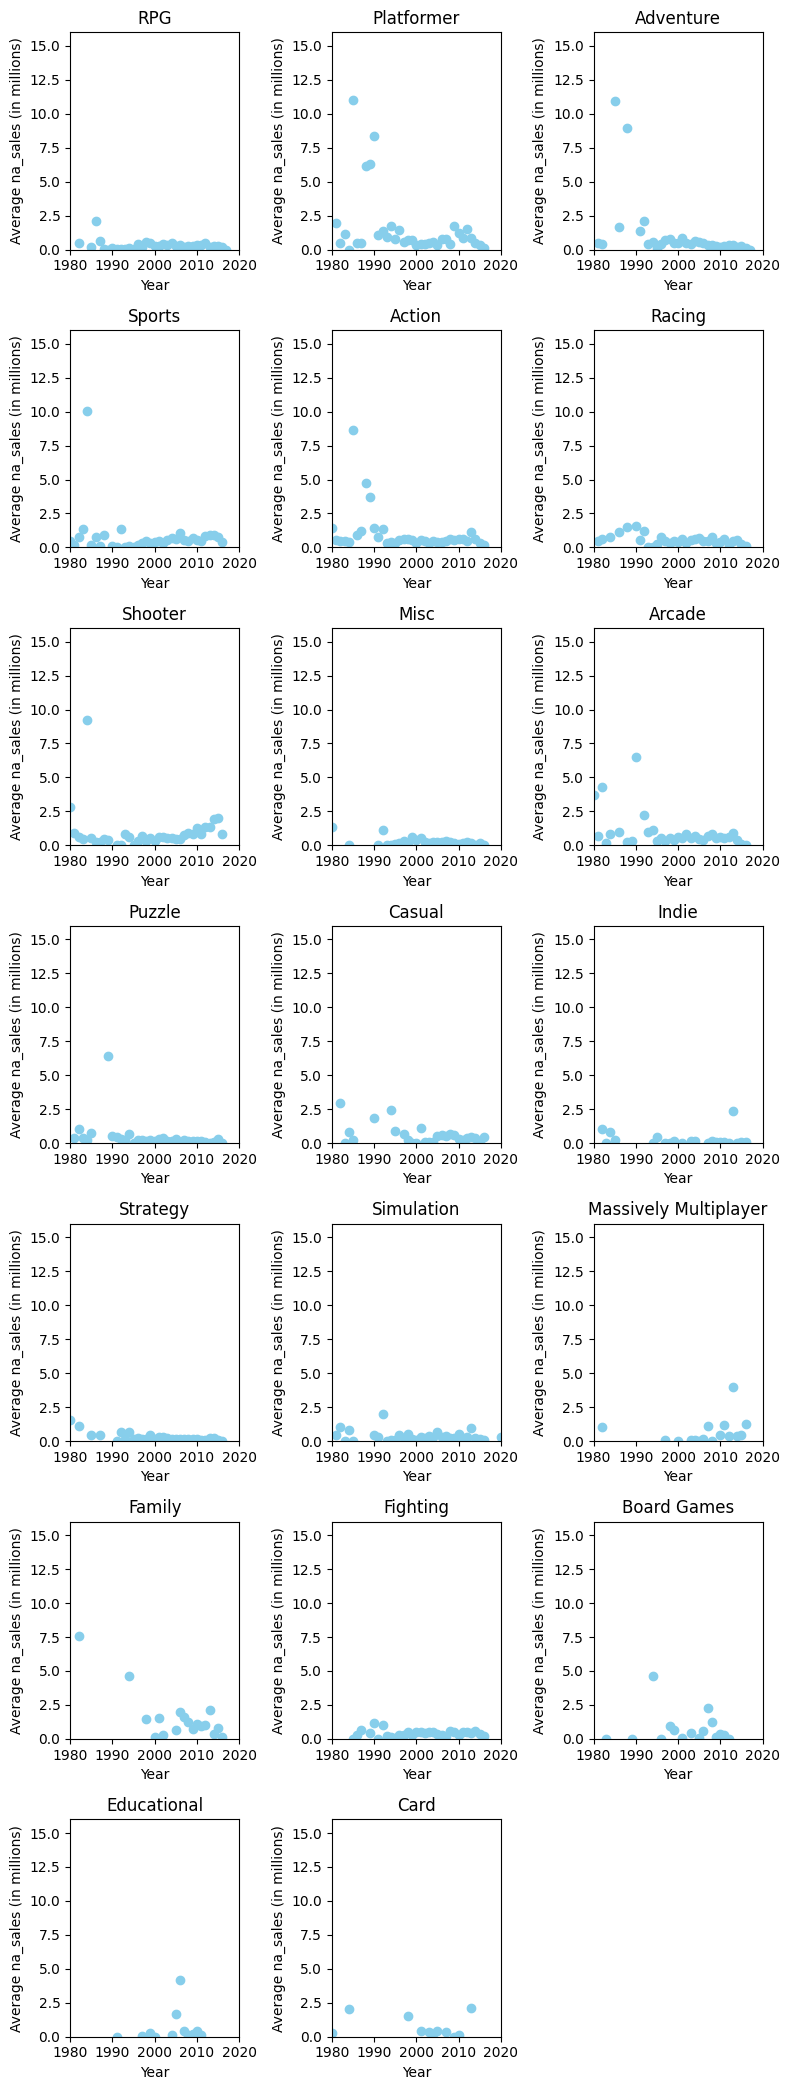

In [48]:
plot_mean_by_genre_per_year('na_sales')

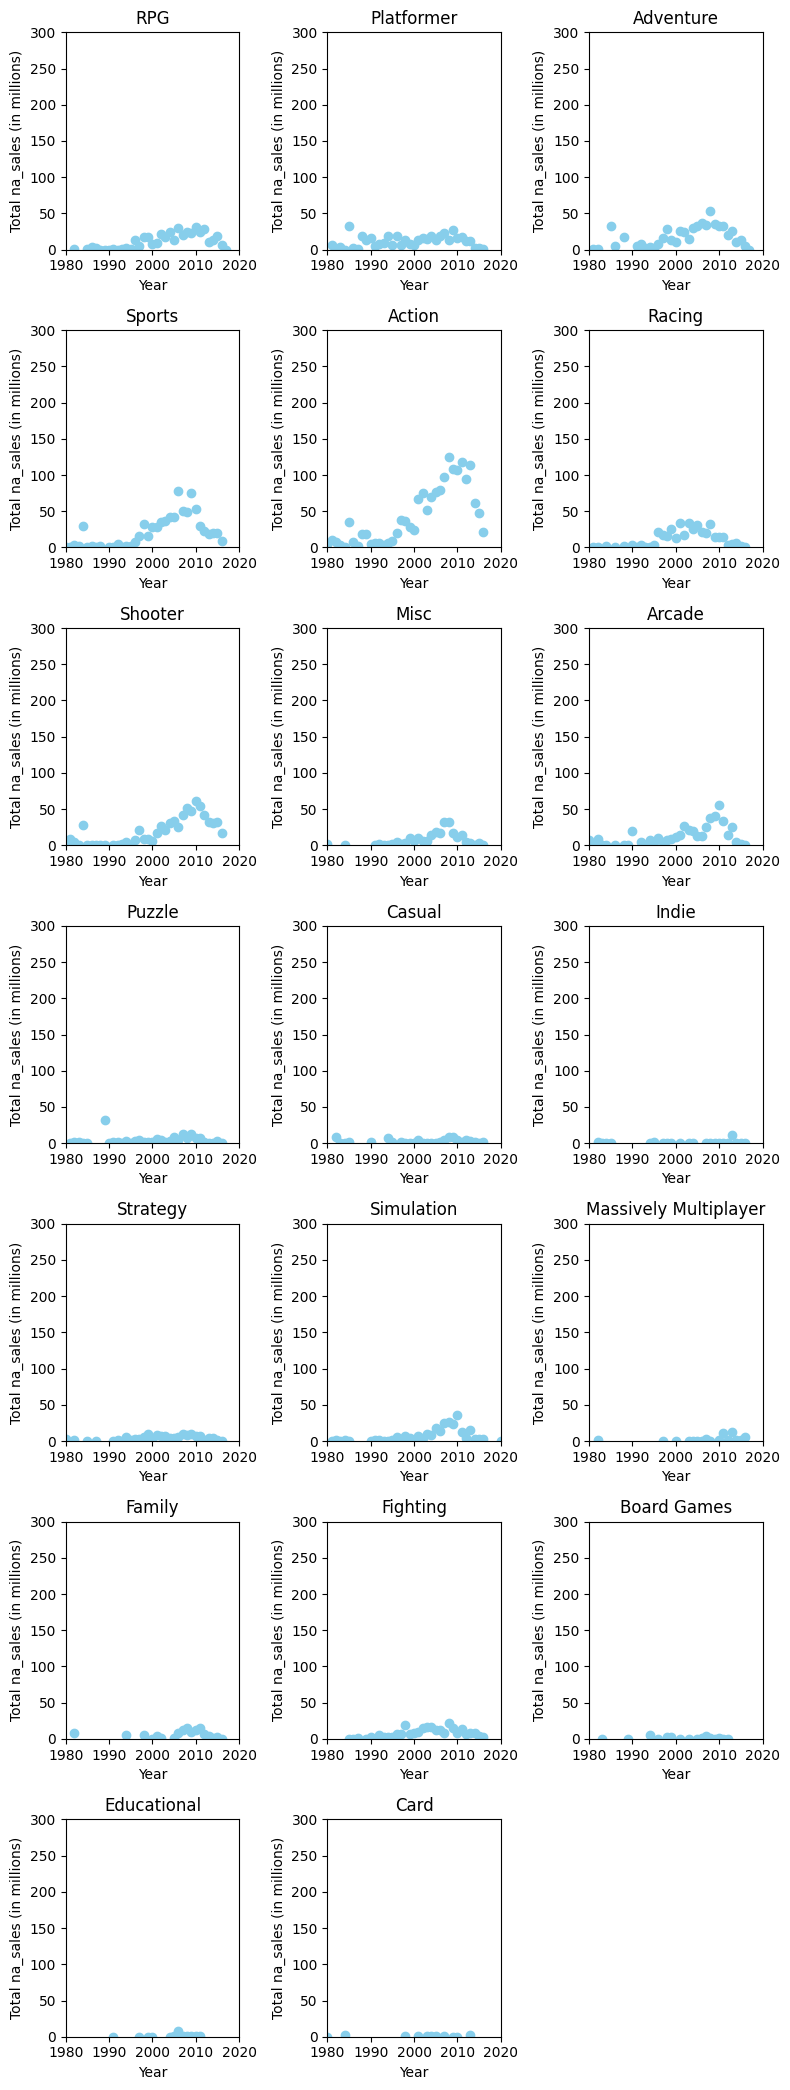

In [49]:
plot_total_by_genre_per_year('na_sales')

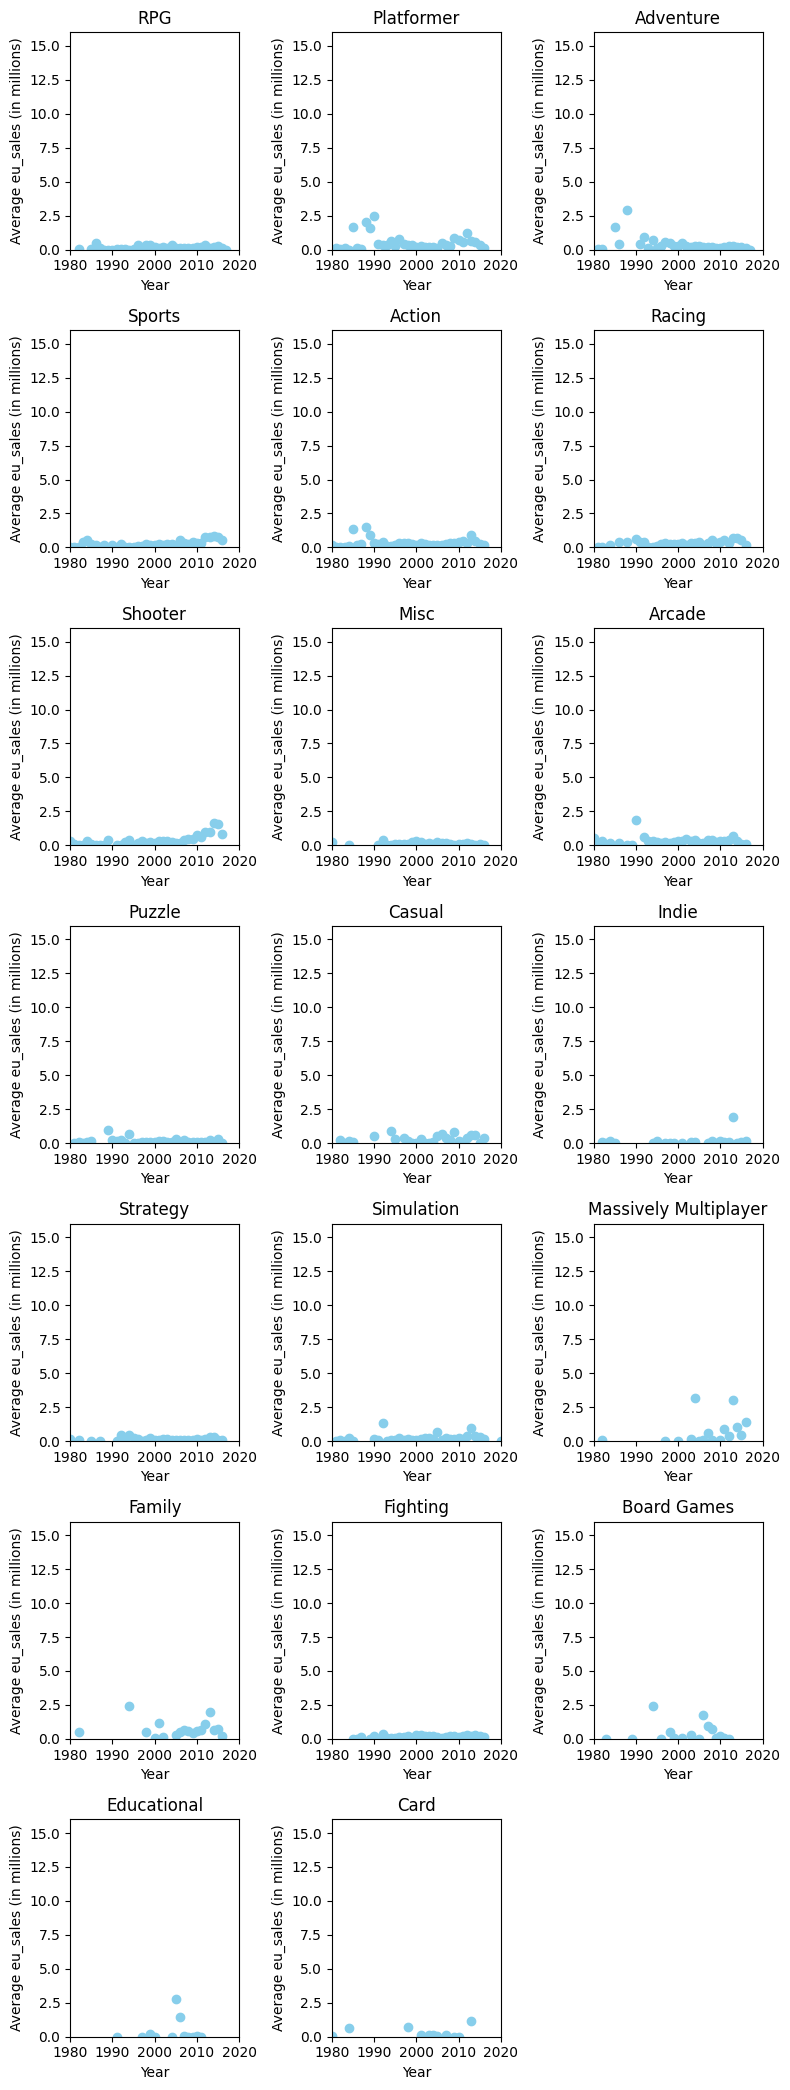

In [50]:
plot_mean_by_genre_per_year('eu_sales')

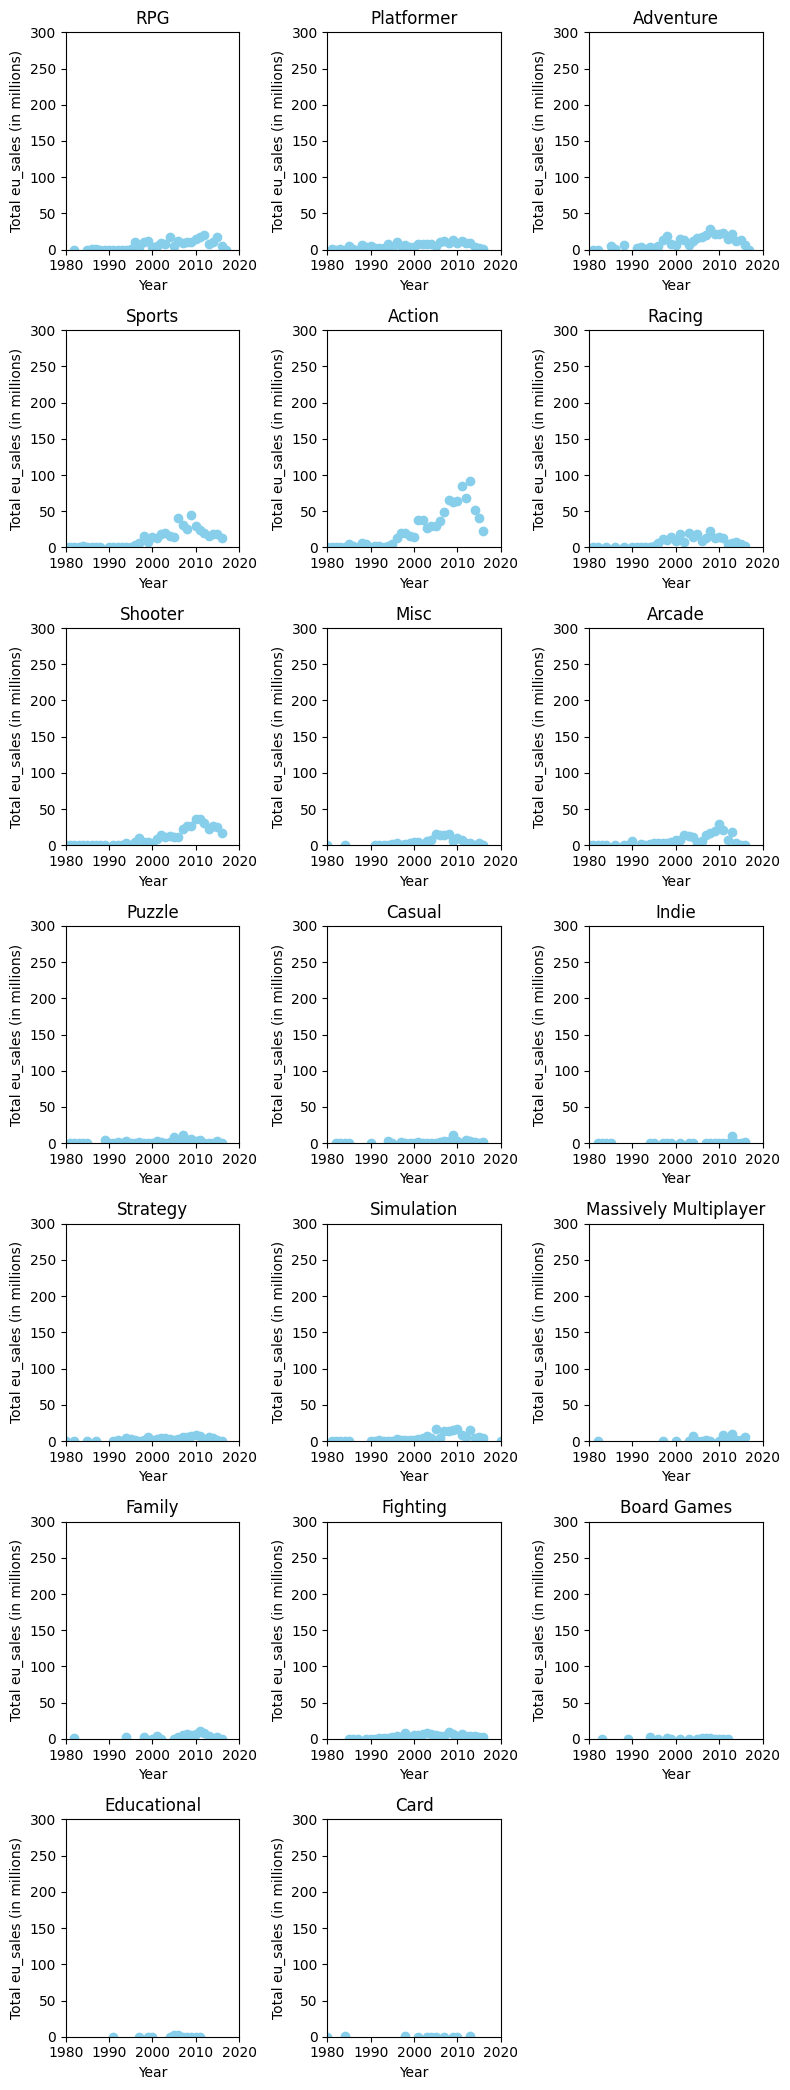

In [51]:
plot_total_by_genre_per_year('eu_sales')

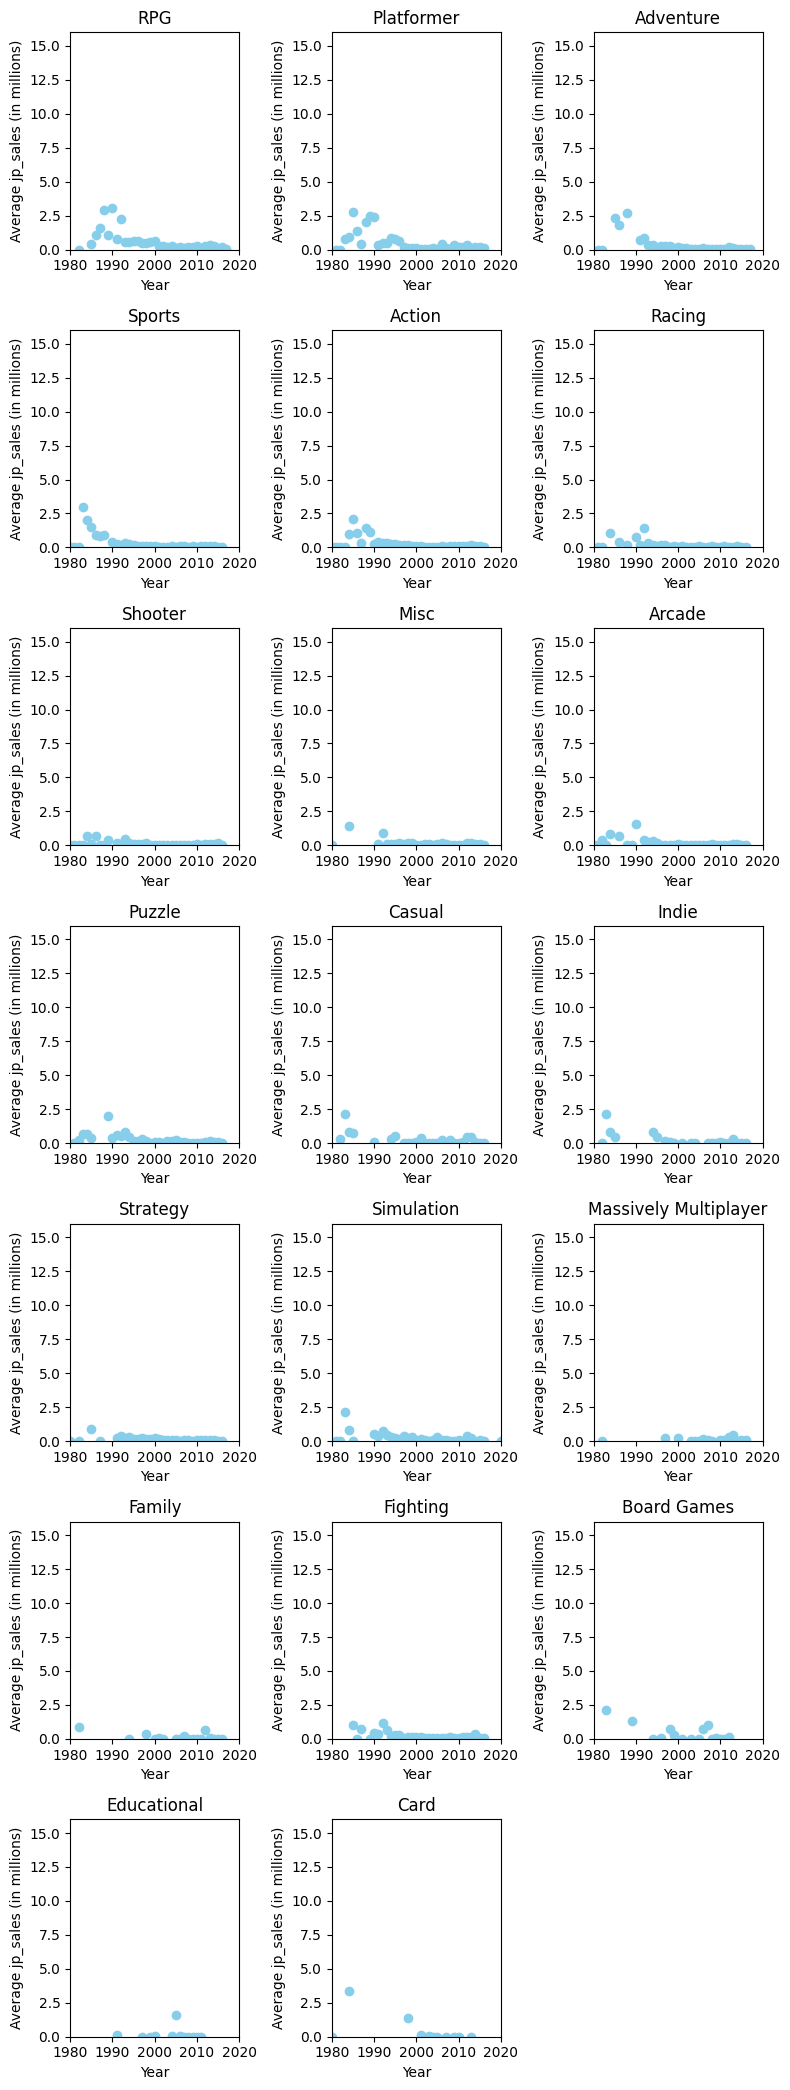

In [52]:
plot_mean_by_genre_per_year('jp_sales')

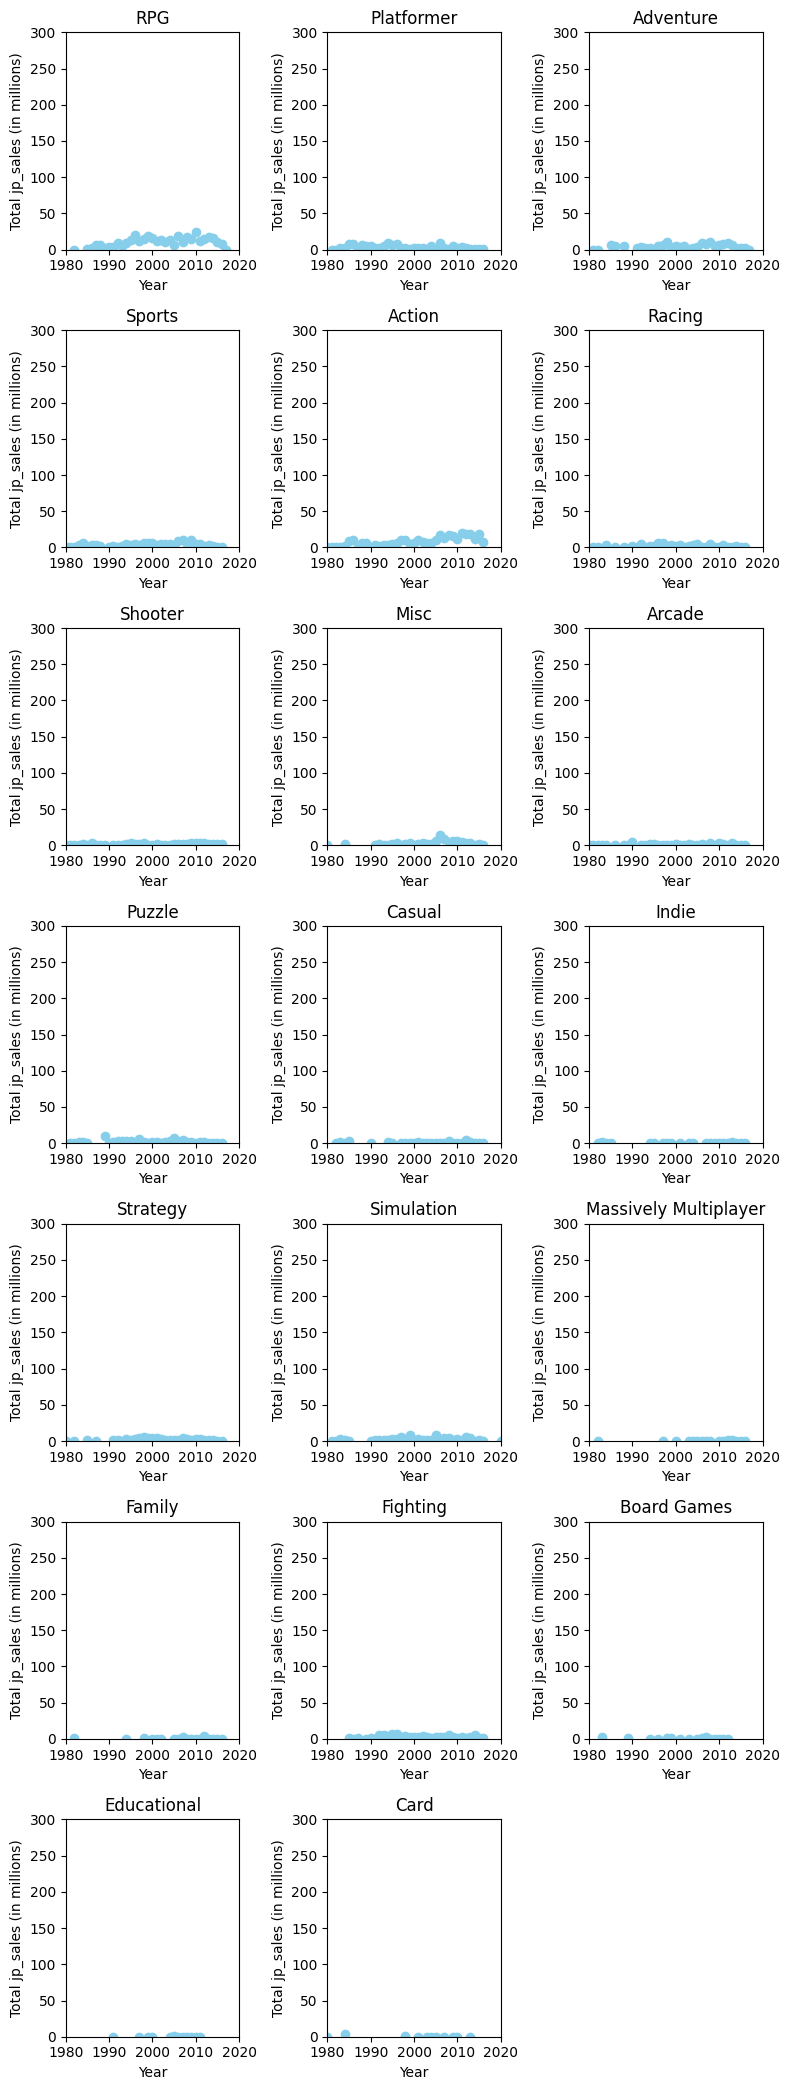

In [53]:
plot_total_by_genre_per_year('jp_sales')

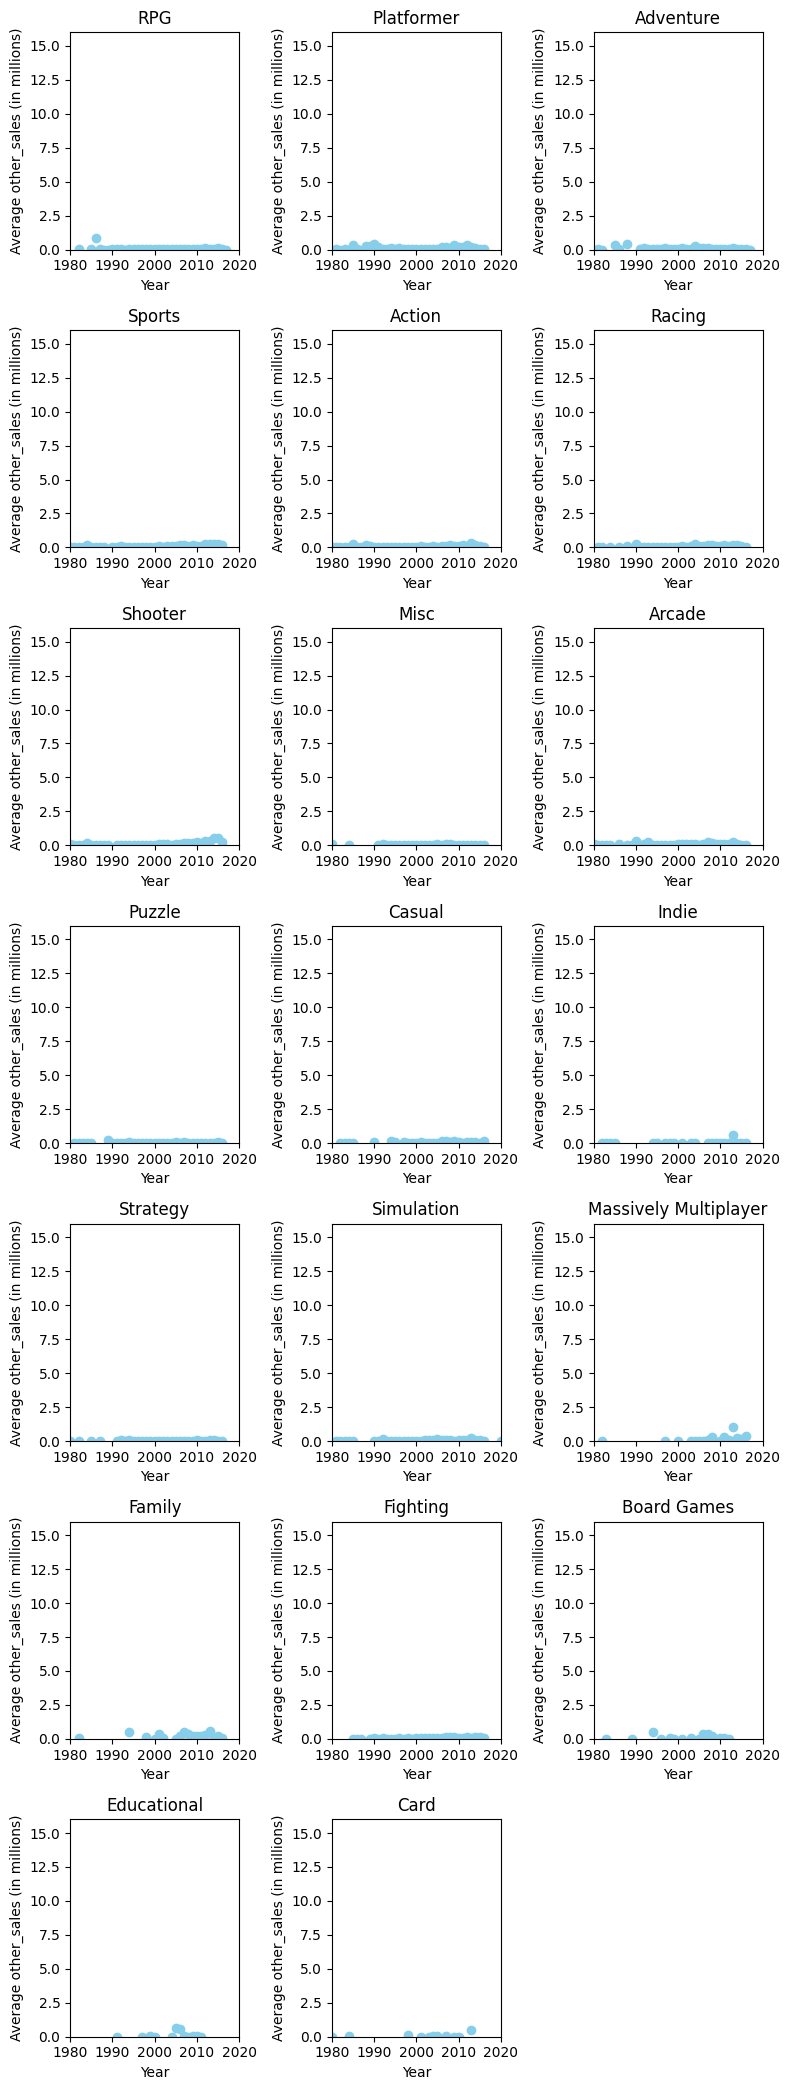

In [55]:
plot_mean_by_genre_per_year('other_sales')

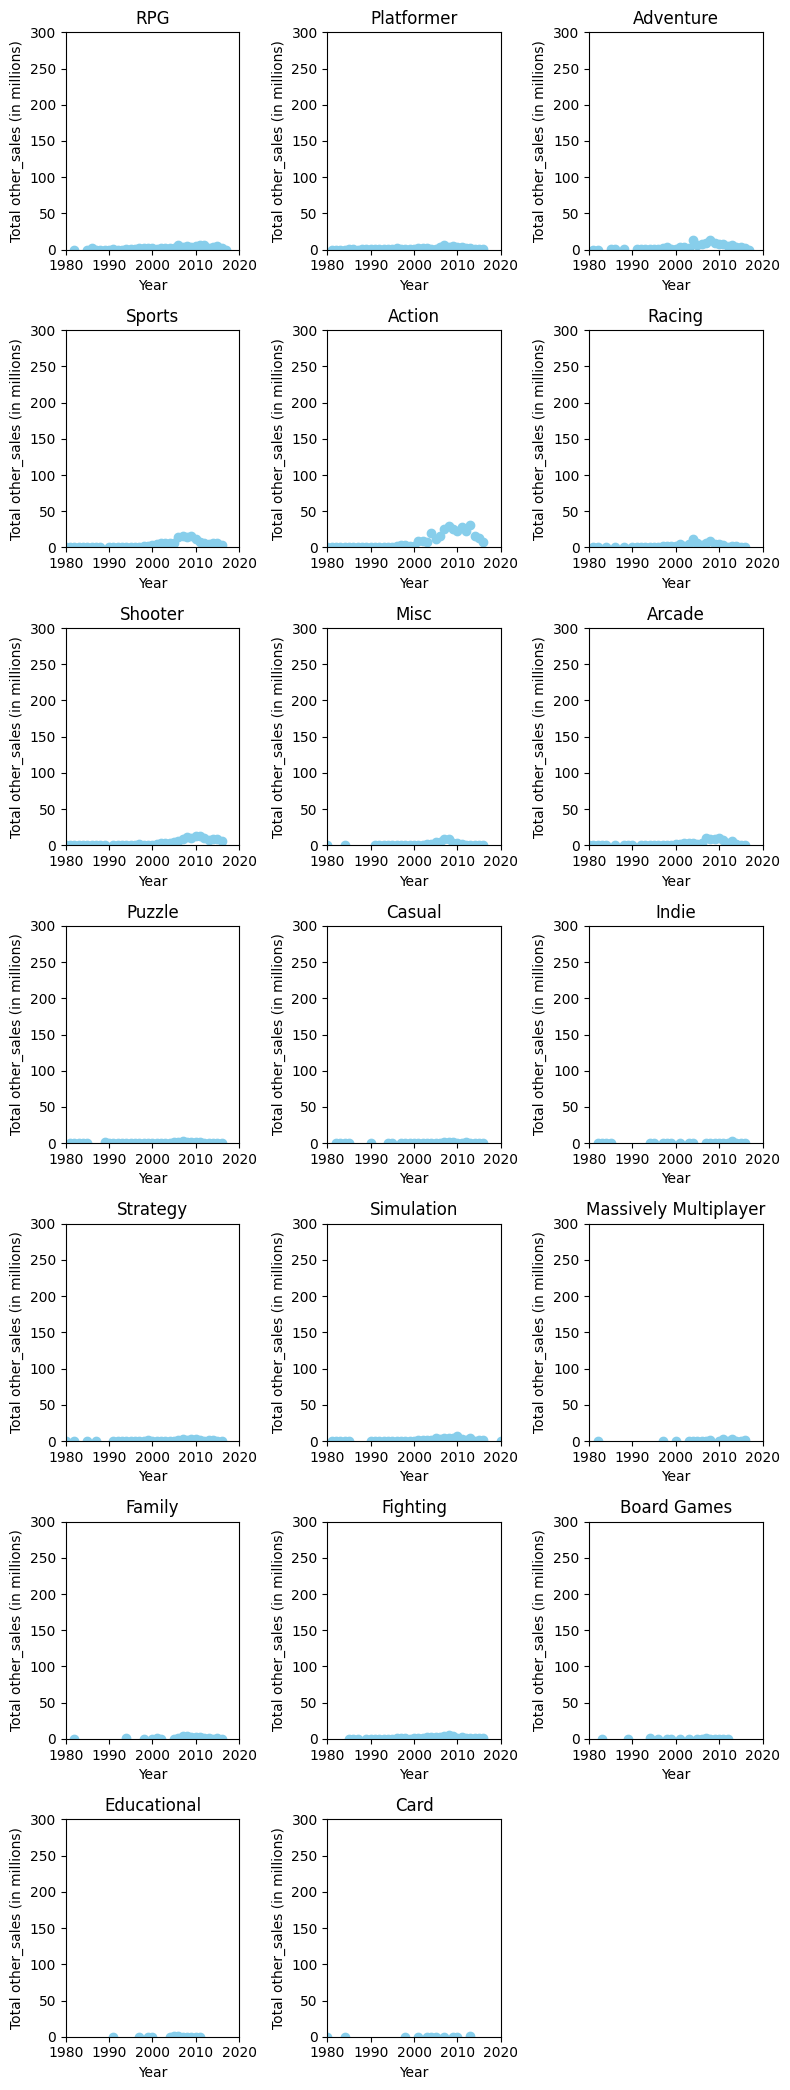

In [56]:
plot_total_by_genre_per_year('other_sales')

We are using a different subset of the data in the time analysis, so we create a new dataframe. 

In [72]:
# Read the CSV files
df1 = pd.read_csv('game_info.csv')
df2 = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

# Standardizing the column names
df2.columns = df2.columns.str.lower()
df1.columns = df1.columns.str.lower()

# This will only keep rows where the 'name' is found in both dataframes
merged_df = pd.merge(df2, df1, on='name', how='left', suffixes=('_df2', '_df1'))
merged_df = merged_df.dropna(subset=['released'])

columns_to_drop=['year_of_release', 'genre', 'platform', 'publisher', 'critic_score',
       'critic_count', 'user_score', 'user_count', 'developer', 'rating_df2',
       'id', 'slug', 'metacritic', 'tba', 'updated', 'website',
       'rating_df1', 'rating_top', 'playtime', 'achievements_count',
       'ratings_count', 'suggestions_count', 'game_series_count',
       'reviews_count', 'platforms', 'developers', 'publishers', 'esrb_rating',
       'added_status_yet', 'added_status_owned', 'added_status_beaten',
       'added_status_toplay', 'added_status_dropped', 'added_status_playing', 'genres']
# Drop the redundant columns
result_df = merged_df.drop(columns=columns_to_drop)

result_df['released'] = pd.to_datetime(result_df['released'])
result_df['month_day'] = result_df['released'].dt.strftime('%m-%d')
result_df['month'] = result_df['released'].dt.month
result_df['day'] = result_df['released'].dt.day
result_df = result_df.sort_values(by='month_day')

# remove outlier
result_df = result_df[result_df['month_day'] != '01-01'] 
result_df

,name,na_sales,eu_sales,jp_sales,other_sales,global_sales,released,month_day,month,day
969,Virtua Fighter 4,0.78,0.44,0.56,0.04,1.81,2001-01-02,01-02,1,2
8022,Hidden Mysteries: Vampire Secrets,0.06,0.11,0.00,0.02,0.18,2013-01-02,01-02,1,2
14306,CT Special Forces,0.02,0.01,0.00,0.00,0.03,2001-01-02,01-02,1,2
1305,Super Monkey Ball,0.95,0.37,0.10,0.04,1.46,2001-01-02,01-02,1,2
2006,UFC Undisputed 3,0.55,0.32,0.03,0.13,1.03,2012-01-03,01-03,1,3
...,...,...,...,...,...,...,...,...,...,...
3435,Q*bert,0.55,0.03,0.00,0.01,0.58,1982-12-31,12-31,12,31
2074,NBA Live 97,0.55,0.38,0.00,0.07,1.00,1996-12-31,12-31,12,31
4652,The Suffering,0.20,0.16,0.00,0.05,0.42,2003-12-31,12-31,12,31
7200,The Suffering,0.16,0.05,0.00,0.01,0.22,2003-12-31,12-31,12,31


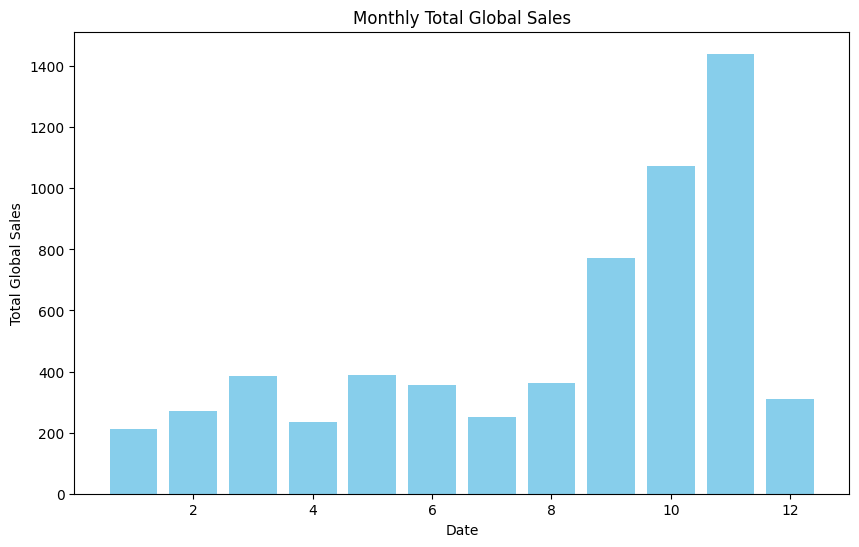

month_day        11-19
global_sales    132.25
Name: 322, dtype: object


In [66]:
monthly_sales = result_df.groupby('month')['global_sales'].sum().reset_index()
#daily_sales = result_df.groupby('month_day')['global_sales'].sum().reset_index()

# Plot the monthly global sales
plt.figure(figsize=(10, 6))
plt.bar(monthly_sales['month'], monthly_sales['global_sales'], color='skyblue')
plt.title('Monthly Total Global Sales')
plt.xlabel('Date')
plt.ylabel('Total Global Sales')
plt.show()
day_with_highest_sales = daily_sales.loc[daily_sales['global_sales'].idxmax()]
print(day_with_highest_sales)

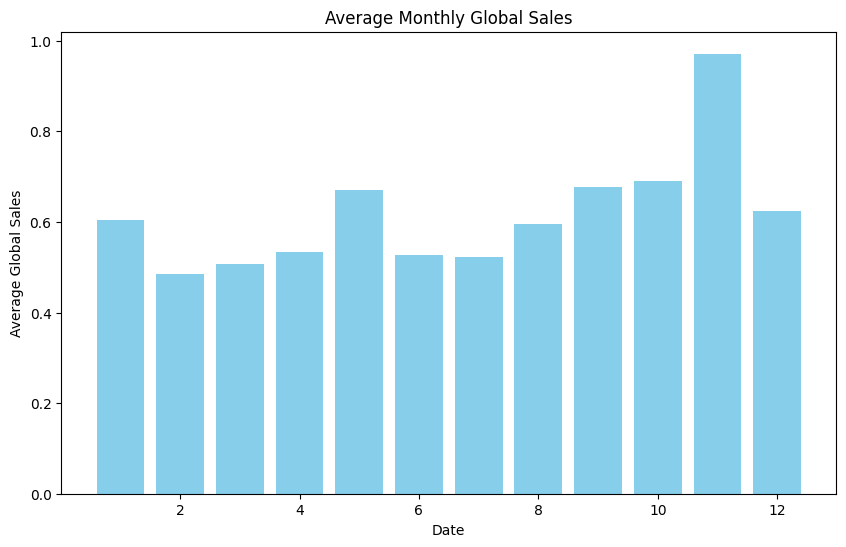

In [67]:
# Calculate average sales per month
average_sales = result_df.groupby(result_df['month'])['global_sales'].mean().reset_index()

# Plot the average monthly global sales
plt.figure(figsize=(10, 6))
plt.bar(average_sales['month'], average_sales['global_sales'], color='skyblue')
plt.title('Average Monthly Global Sales')
plt.xlabel('Date')
plt.ylabel('Average Global Sales')
plt.show()


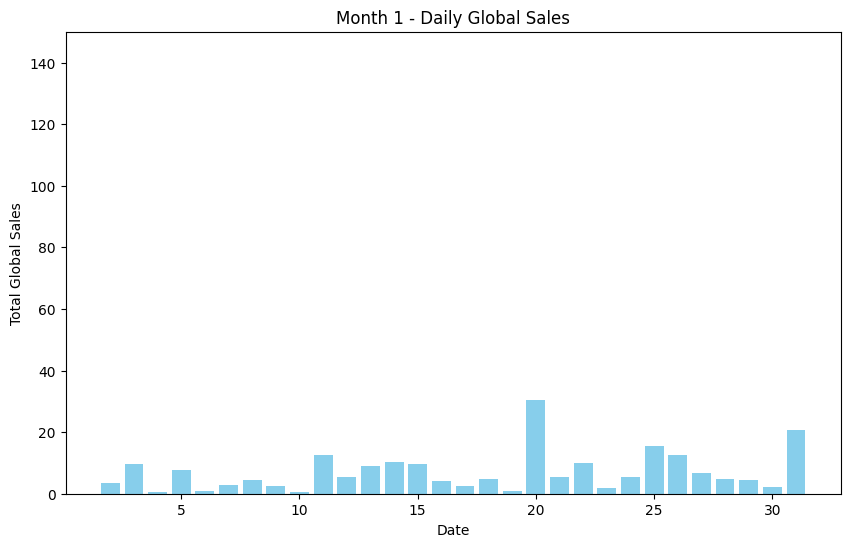

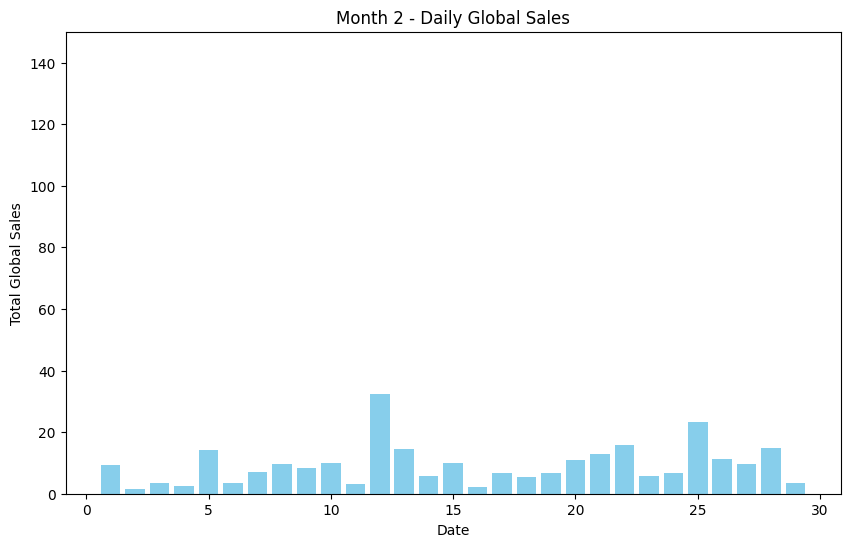

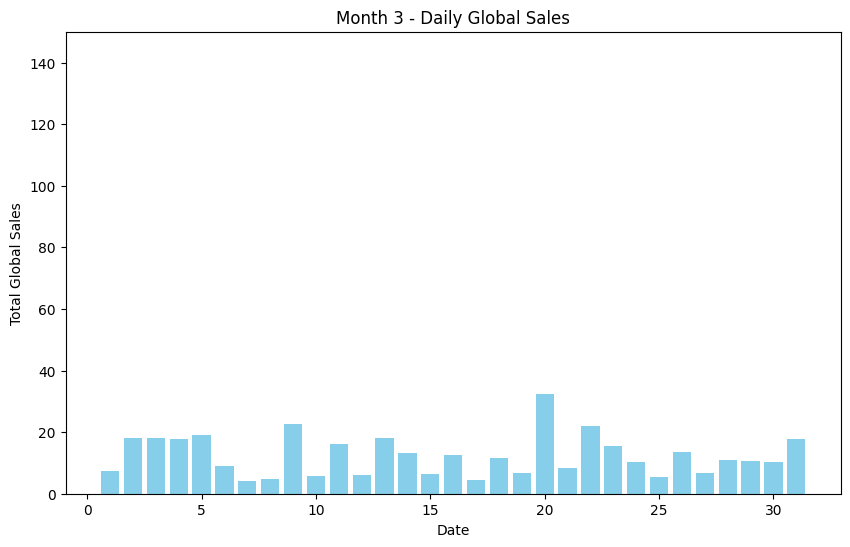

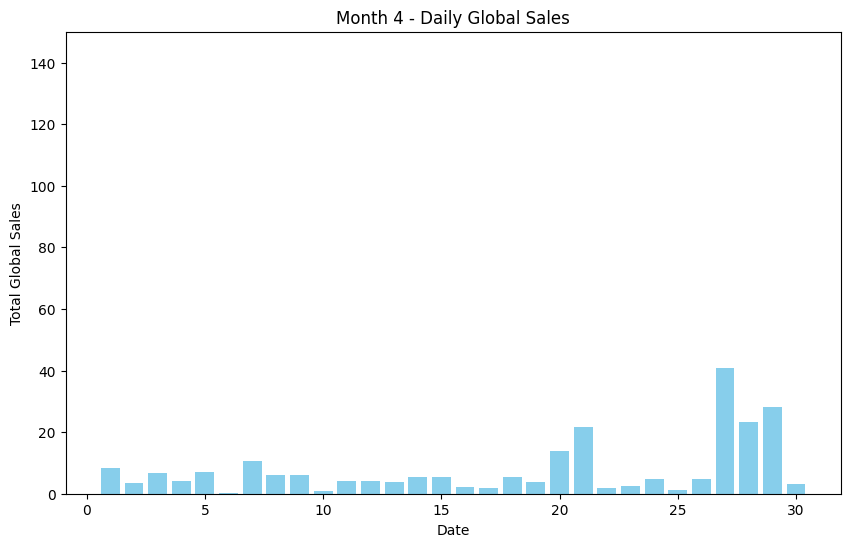

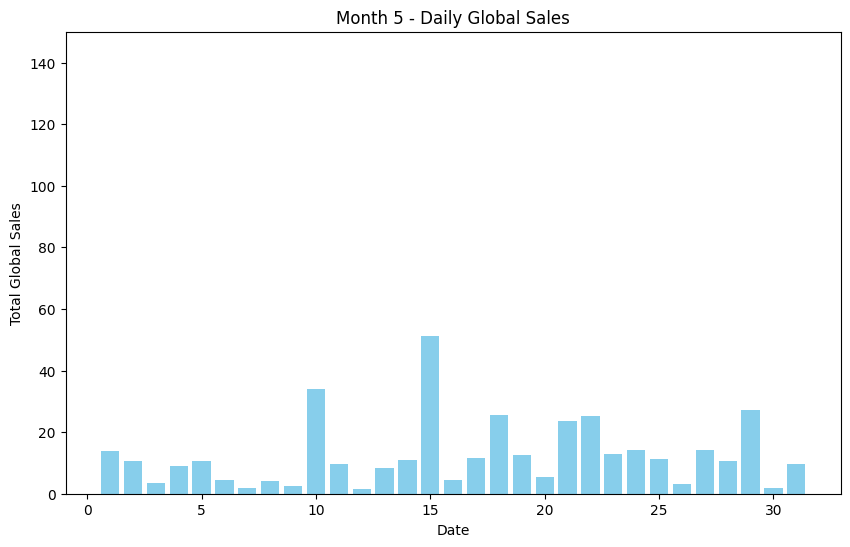

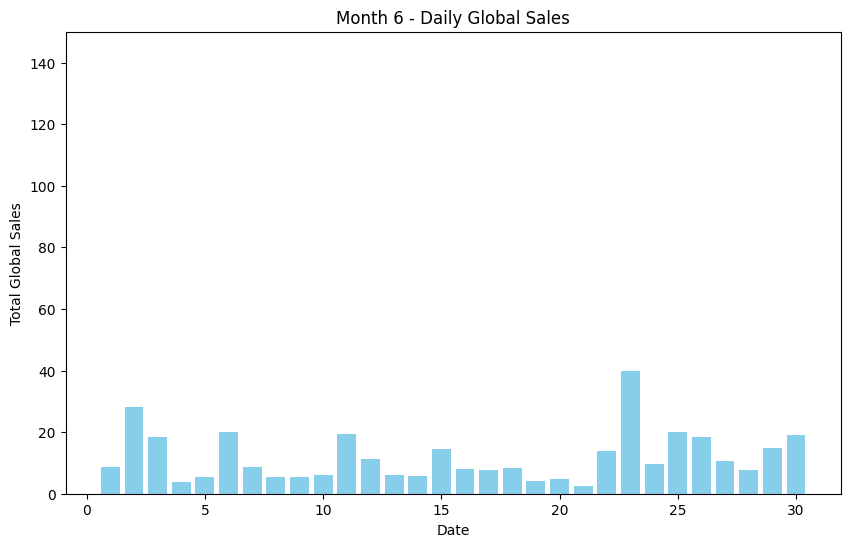

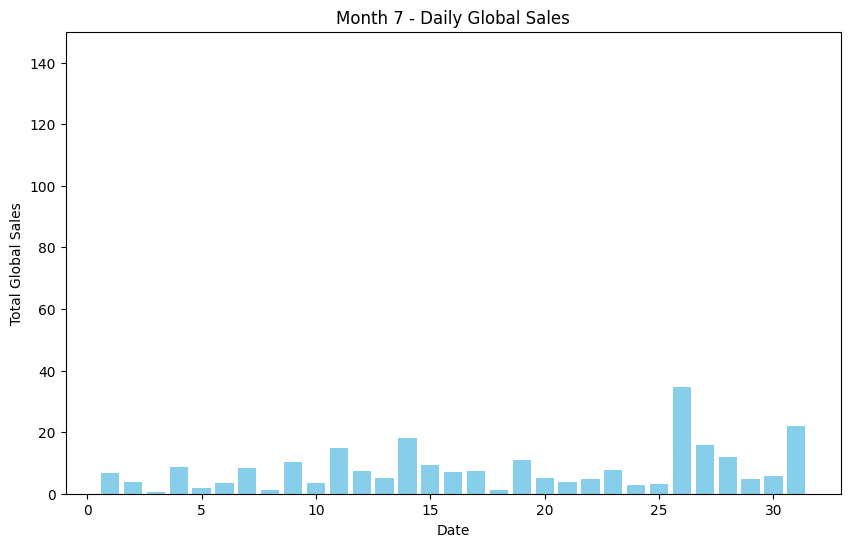

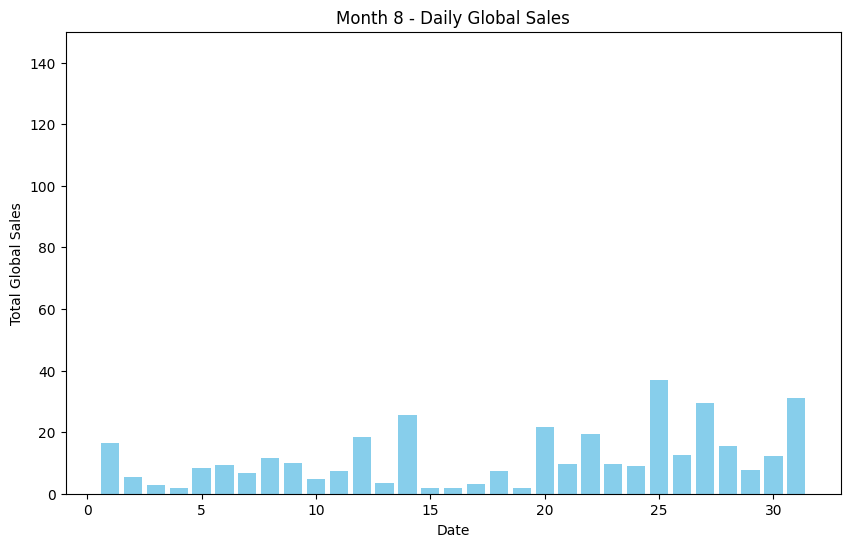

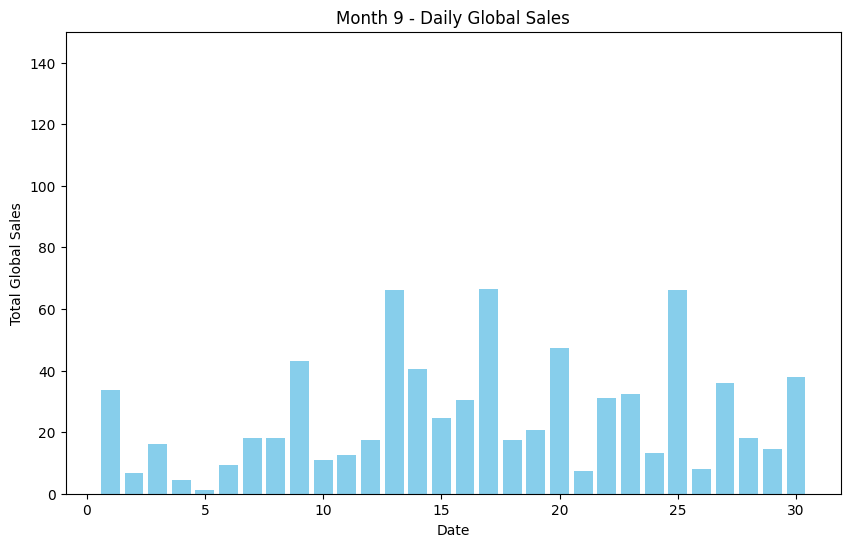

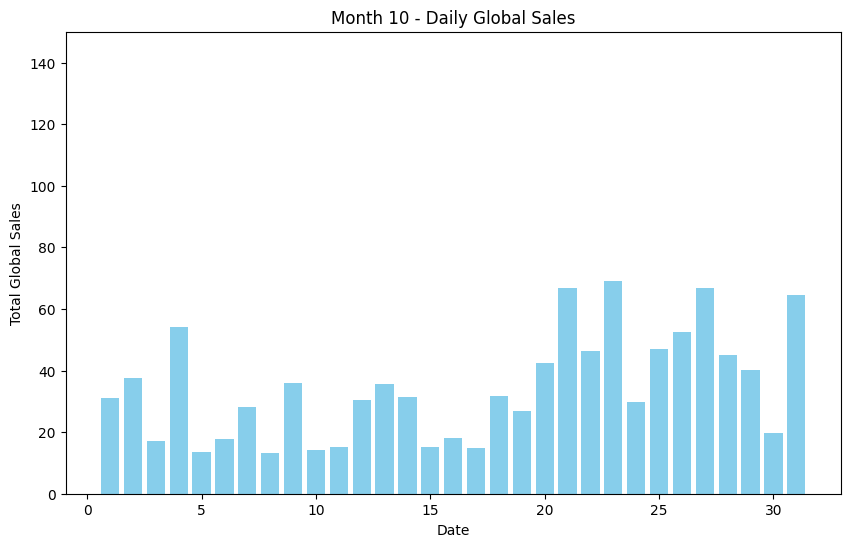

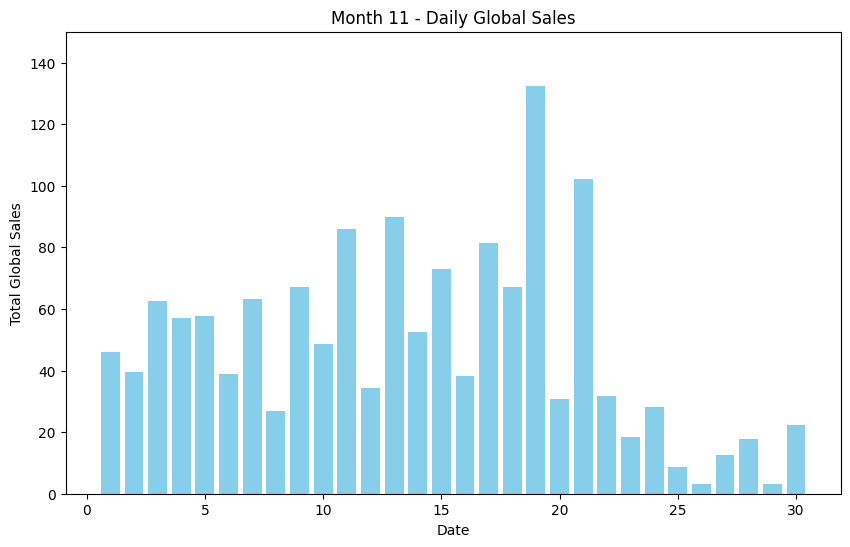

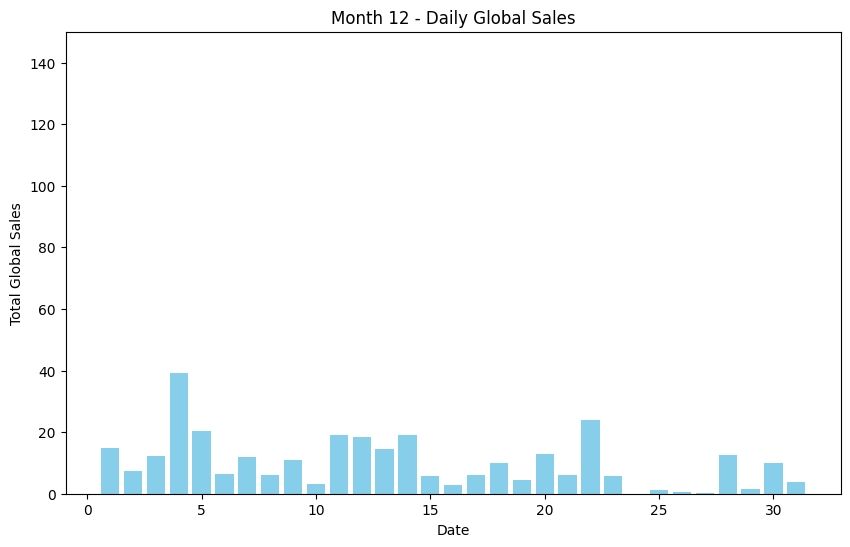

month_day        11-19
global_sales    132.25
Name: 322, dtype: object


In [74]:
daily = result_df.groupby('month_day')['global_sales'].sum().reset_index()

unique_months = result_df['month'].unique()

for month in unique_months:
    month_data = result_df[result_df['month'] == month]
    daily_sales = month_data.groupby('day')['global_sales'].sum().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(daily_sales['day'], daily_sales['global_sales'], color='skyblue')
    plt.title(f'Month {month} - Daily Global Sales')
    plt.xlabel('Date')
    plt.ylabel('Total Global Sales')
    plt.ylim(0, 150)
    
    plt.show()

day_with_highest_sales = daily.loc[daily['global_sales'].idxmax()]
print(day_with_highest_sales)